<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/Chapter8_%EC%88%98%EC%97%85%20%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


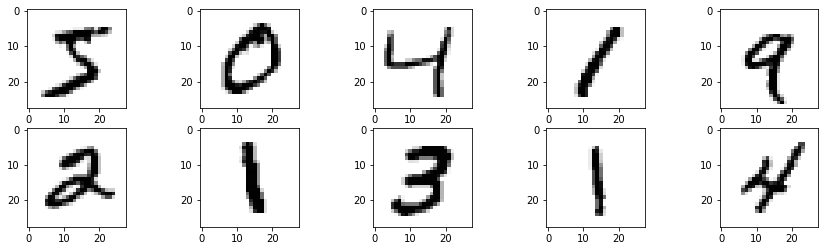

In [3]:
fig = plt.figure(figsize=(15, 4))

for i in range(10):
    plottable_image = np.reshape(x_train_all[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(plottable_image, cmap='gray_r')

In [4]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [5]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid))

학습 데이터셋 클래스별 샘플 수 :  [4738 5394 4766 4905 4674 4337 4734 5012 4681 4759]
평가 데이터셋 클래스별 샘플 수 :  [1185 1348 1192 1226 1168 1084 1184 1253 1170 1190]


In [6]:
x_train = x_train / 255
x_valid = x_valid / 255 
x_test = x_test / 255

In [7]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [8]:
import torch
x_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.FloatTensor(y_train_encoded)
x_valid_torch = torch.FloatTensor(x_valid)
y_valid_torch = torch.FloatTensor(y_valid_encoded) 
x_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.FloatTensor(y_test)

In [9]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [10]:
class MNISTDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y
  
  def collate_fn(self, batch):
    x, y = zip(*batch)
    return x, y

  def __len__(self):
    return len(self.x_data)

In [11]:
dataset = MNISTDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [25]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding='same'),      
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(in_channels=10, out_channels=1, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3),
        nn.Dropout(0.3),
    )
    
    self.linear = nn.Linear(81, 10)
  
  def forward(self, x):
    output = self.net(x)
    output = output.view(-1, 1, 81)
    output = self.linear(output)
    return output 

In [31]:
model = MyModel()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

global_step = 0 
for epoch in range(10):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch.unsqueeze(1))
    loss = criterion(output.squeeze(1), y_batch)
    model.zero_grad() 
    optim.zero_grad()
    loss.backward()
    optim.step()

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))

  with torch.no_grad():
    model.eval()
    predicts = model(x_valid_torch.unsqueeze(1))
    predicts = torch.argmax(predicts.squeeze(1), 1)

    correct = 0 
    for i in range(len(predicts)):
      if predicts[i].item() == y_valid[i]:
        correct += 1
    acc = correct / len(predicts)
    print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))
    model.train()

epoch: 1 | global_step:     1500 | loss: 1.3375: 100%|██████████| 1500/1500 [01:12<00:00, 20.65it/s]


epoch: 1 | global_step: 1500 | valid acc: 77.541667%


epoch: 2 | global_step:     3000 | loss: 1.2540: 100%|██████████| 1500/1500 [01:09<00:00, 21.53it/s]


epoch: 2 | global_step: 3000 | valid acc: 82.341667%


epoch: 3 | global_step:     4500 | loss: 0.8398: 100%|██████████| 1500/1500 [01:07<00:00, 22.09it/s]


epoch: 3 | global_step: 4500 | valid acc: 83.941667%


epoch: 4 | global_step:     6000 | loss: 0.5431: 100%|██████████| 1500/1500 [01:09<00:00, 21.60it/s]


epoch: 4 | global_step: 6000 | valid acc: 84.975000%


epoch: 5 | global_step:     7500 | loss: 0.6273: 100%|██████████| 1500/1500 [01:07<00:00, 22.17it/s]


epoch: 5 | global_step: 7500 | valid acc: 85.358333%


epoch: 6 | global_step:     9000 | loss: 0.4324: 100%|██████████| 1500/1500 [01:08<00:00, 21.86it/s]


epoch: 6 | global_step: 9000 | valid acc: 85.883333%


epoch: 7 | global_step:    10500 | loss: 0.4499: 100%|██████████| 1500/1500 [01:09<00:00, 21.73it/s]


epoch: 7 | global_step: 10500 | valid acc: 85.916667%


epoch: 8 | global_step:    12000 | loss: 0.7485: 100%|██████████| 1500/1500 [01:30<00:00, 16.66it/s]


epoch: 8 | global_step: 12000 | valid acc: 86.200000%


epoch: 9 | global_step:    13500 | loss: 1.2479: 100%|██████████| 1500/1500 [01:28<00:00, 16.90it/s]


epoch: 9 | global_step: 13500 | valid acc: 85.908333%


epoch: 10 | global_step:    15000 | loss: 0.8275: 100%|█████████| 1500/1500 [01:29<00:00, 16.72it/s]


epoch: 10 | global_step: 15000 | valid acc: 86.433333%


In [32]:
with torch.no_grad():
  model.eval()
  predict = model(x_test_torch.unsqueeze(1))
  predict = torch.argmax(predict.squeeze(1), 1)

In [33]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))

Test accuracy : 87.26%


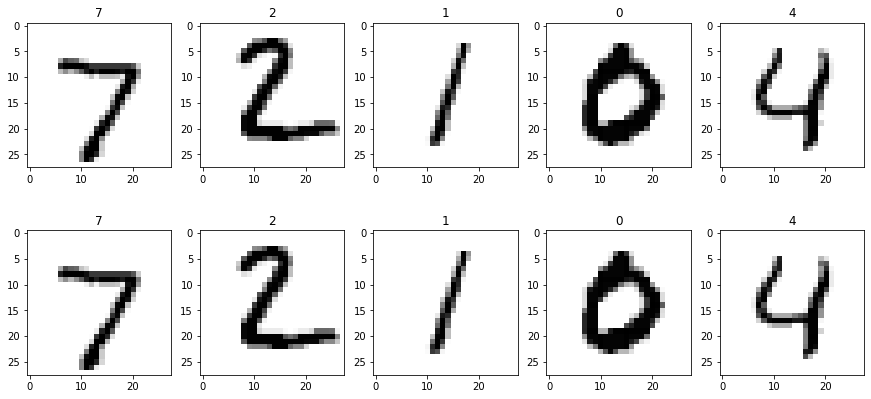

In [35]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test[i]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(str(y_test[i]))
    ax.imshow(plottable_image, cmap='gray_r')
  
for i in range(5):
    plottable_image = x_test[i]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(str(predict[i].item()))
    ax.imshow(plottable_image, cmap='gray_r')

plt.show()